# Demonstration Querying Livestock data

Here we demonstrate querying linked-livestock data over the Agrimetrics GraphQL API. We take the approach of constructing the query statements using the Agrimetrics Query Builder https://app.agrimetrics.co.uk/#/graph-explorer, then use the "Export Code" option to get the Python 3 code for the query, which we can run in this Jupyter notebook and then analyse.

Details of the Demonstration Linked Livestock data are given here https://app.agrimetrics.co.uk/#/catalog/data-sets/b8543f8a-576e-44e7-ad60-7501106482ff

We demonstrate two queries here. The first shows the extraction of data from a JSON structure that does not immediately lend itself to being viewed as a 2-dimensional table. For that we work with the milk spectrum data. The second involves querying both cow location data AND weather and crop type data for the same general area to show how cow, field and weather data for the same general location.

## 1. Querying milk spectrum data

We first go to https://app.agrimetrics.co.uk/#/graph-explorer and paste the query below into the middle panel (replacing the existing) query

Next run the query to ensure it works. It should result in JSON code in the right hand window showing the data.

Next we click "Export Code" and the code export window pops up. It should already be set to showing "Python 3" code. 

Click the "Show API Credentials" button to obtain your API key. Run the following cell to insert the API key and enable this notebook.

In [1]:
import os

API_KEY = os.environ.get('API_KEY')
if API_KEY is None: 
    API_KEY = input("Please enter your API key:")

Please enter your API key:


In [2]:
# Python 3
import requests

url = "https://api.agrimetrics.co.uk/graphql"

payload = {"query":" query getMilkSpectra { demoDataSets { livestockDemo { observations(where: {observationType: {EQ: MILK}}) { ... on MilkObservation { dateTime observationType milkSpectrum { unit intensity wavenumber } } } } } }"}
headers = {
    'Accept': "application/json",
    'Ocp-Apim-Subscription-Key': API_KEY,
    'Content-Type': "application/json",
    'Accept-Encoding': "gzip, deflate, br",
}

response = requests.request("POST", url, json=payload, headers=headers)

That code should simply run right away and store the results in the "response" variable.  We next extract the JSON data from that response and convert it into a Pandas DataFrame. 

In [3]:
import json
import pandas as pd
from pandas.io.json import json_normalize

JSONOutput = json.loads(response.text)
tableOutput=pd.DataFrame(JSONOutput)
observationList = pd.DataFrame(pd.DataFrame(tableOutput.iat[0,0]).iat[0,0])
observationList

,dateTime,observationType,milkSpectrum
0,2018-02-01T00:00:00.000Z,MilkObservation,None
1,2018-02-01T00:00:00.000Z,MilkObservation,None
2,2018-02-01T00:00:00.000Z,MilkObservation,None
3,2018-02-01T00:00:00.000Z,MilkObservation,None
4,2018-02-01T00:00:00.000Z,MilkObservation,None
...,...,...,...
105,2018-03-29T10:00:00.000Z,MilkObservation,"[{'unit': 'Per Centimetre', 'intensity': 0.625..."
106,2018-03-30T00:00:00.000Z,MilkObservation,None
107,2018-03-30T10:00:00.000Z,MilkObservation,"[{'unit': 'Per Centimetre', 'intensity': 0.782..."
108,2018-03-31T10:00:00.000Z,MilkObservation,"[{'unit': 'Per Centimetre', 'intensity': 0.823..."


Now we can extract some spectrum data from that data structure. For now let's just pull out an individual spectrum associated with one observation and plot it in a graph.

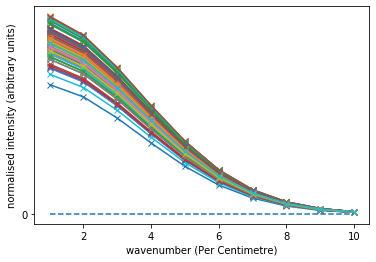

In [5]:
import matplotlib.pyplot as plt

filteredObservations = observationList[observationList.milkSpectrum.notnull()]

for spectrumObservation in filteredObservations.milkSpectrum:
    spectrumTable=pd.DataFrame(spectrumObservation)
    sortedSpectrumTable = spectrumTable.sort_values(by='wavenumber')
    plt.plot(sortedSpectrumTable.wavenumber,sortedSpectrumTable.intensity, '-x')

# Formatting 
plt.xlabel('wavenumber (Per Centimetre)')
plt.ylabel('normalised intensity (arbitrary units)')
plt.yticks([0], [0])
plt.plot([1, 10], [0, 0], linestyle='--')
plt.show()

## 2. Querying livestock and weather data together

As before, we first go to https://app.agrimetrics.co.uk/#/graph-explorer and paste the query below into the middle panel (replacing the existing) query

Next tun the query as before to ensure it work and then click "Export Code" export the code as before. The code should look somethign like this (but you'll need to ensure your API key is in it):

In [7]:
# Python 3
import requests

url = "https://api.agrimetrics.co.uk/graphql"

payload = {"query":"query getCowLocations { demoDataSets { livestockDemo { cow { id grazing { location { dateTime observationType point } } } } } }"}
headers = {
    'Accept': "application/json",
    'Ocp-Apim-Subscription-Key': API_KEY,
    'Content-Type': "application/json",
    'Accept-Encoding': "gzip, deflate, br",
}

response = requests.request("POST", url, json=payload, headers=headers)

That code should simply run right away and store the results in the "response" variable. We next extract the JSON data from that response and convert it into a normalized Pandas DataFrame. 

In [8]:
import json
import pandas as pd
from pandas.io.json import json_normalize

full_json = json.loads(response.text)
data = full_json['data']['demoDataSets']['livestockDemo']

cow_location_details = json_normalize(
    data['cow'],
    record_path=['grazing', 'location'],
    meta=['id'],
    errors='ignore',
)

cow_location_details.drop(['observationType', 'point.type'], axis=1, inplace=True)
cow_location_details

,dateTime,point.coordinates,id
0,2018-07-07T01:00:00.000Z,"[-0.936306924, 51.40829159]",https://data.agrimetrics.co.uk/animals/900192796
1,2018-07-01T09:00:00.000Z,"[-0.936115928, 51.40835539]",https://data.agrimetrics.co.uk/animals/900192796
2,2018-07-02T21:00:00.000Z,"[-0.936301449, 51.40808253]",https://data.agrimetrics.co.uk/animals/900192796
3,2018-07-06T17:00:00.000Z,"[-0.936567033, 51.40814309]",https://data.agrimetrics.co.uk/animals/900192796
4,2018-07-05T19:00:00.000Z,"[-0.936576087, 51.40831302]",https://data.agrimetrics.co.uk/animals/900192796
...,...,...,...
715,2018-07-03T13:00:00.000Z,"[-0.936153648, 51.40831241]",https://data.agrimetrics.co.uk/animals/900655216
716,2018-07-04T13:00:00.000Z,"[-0.936446782, 51.40821167]",https://data.agrimetrics.co.uk/animals/900655216
717,2018-07-03T21:00:00.000Z,"[-0.936408474, 51.40824719]",https://data.agrimetrics.co.uk/animals/900655216
718,2018-07-02T21:00:00.000Z,"[-0.936302158, 51.40829445]",https://data.agrimetrics.co.uk/animals/900655216


Now let's extract the details for an individual cow and its location over time

In [9]:
selectedCow = cow_location_details['id'][0]

location_details = cow_location_details[cow_location_details.id == selectedCow]

# set the type of the dateTime column appropriately 
location_details = location_details.astype({'dateTime': 'datetime64'})
location_details

,dateTime,point.coordinates,id
0,2018-07-07 01:00:00,"[-0.936306924, 51.40829159]",https://data.agrimetrics.co.uk/animals/900192796
1,2018-07-01 09:00:00,"[-0.936115928, 51.40835539]",https://data.agrimetrics.co.uk/animals/900192796
2,2018-07-02 21:00:00,"[-0.936301449, 51.40808253]",https://data.agrimetrics.co.uk/animals/900192796
3,2018-07-06 17:00:00,"[-0.936567033, 51.40814309]",https://data.agrimetrics.co.uk/animals/900192796
4,2018-07-05 19:00:00,"[-0.936576087, 51.40831302]",https://data.agrimetrics.co.uk/animals/900192796
...,...,...,...
67,2018-07-06 11:00:00,"[-0.936445871, 51.40815425]",https://data.agrimetrics.co.uk/animals/900192796
68,2018-07-01 21:00:00,"[-0.936344325, 51.40817094]",https://data.agrimetrics.co.uk/animals/900192796
69,2018-07-03 09:00:00,"[-0.93652364, 51.40833525]",https://data.agrimetrics.co.uk/animals/900192796
70,2018-07-01 11:00:00,"[-0.936300327, 51.40833045]",https://data.agrimetrics.co.uk/animals/900192796


Now we have the positions of the cows (in time and space), we can perform further queries on these data
```graphql
query getFieldData($coordinates: CoordinateScalar!, $date: Date) {
  fields(geoFilter: {location: {type: Point, coordinates: $coordinates}}) {
    id
    sownCrop {
      cropType
      harvestYear
    }
    weatherObservations(where: { date: { GE: $date LE: $date }}) {
      temperatureMinDaily {
        unit
        value
      }
      temperatureMaxDaily {
        unit
        value
      }
      temperatureMeanDaily {
        unit
        value
      }
      rainfallTotalDaily {
        unit
        value
      }
    }
  }
}

```
> Note here we have used two variables in our query, `$coordinates` and `$date`. We can modify the exported code slightly to easily inject the correct variables

In [10]:
def fetchWeatherAndCropData(coordinates, date):
    query_variables = { "coordinates": coordinates, "date": str(date) }
    
    payload = {
        "query":"query getFieldData($coordinates: CoordinateScalar!, $date: Date) { fields(geoFilter: {location: {type: Point, coordinates: $coordinates}}) { id sownCrop { cropType harvestYear } weatherObservations(where: { date: { GE: $date LE: $date }}) { temperatureMinDaily { unit value } temperatureMaxDaily { unit value } temperatureMeanDaily { unit value } rainfallTotalDaily { unit value } } } } ",
        "variables": json.dumps(query_variables)
    }
    headers = {
        'Accept': "application/json",
        'Ocp-Apim-Subscription-Key': API_KEY,
        'Content-Type': "application/json",
        'Accept-Encoding': "gzip, deflate, br",
    }

    response = requests.request("POST", url, json=payload, headers=headers)
    return json.loads(response.text)

With our parametrized query, we can now extract related data.
> Note the following cell may take some time to retrieve all the data as this is being done one request at a time to keep the example code simple. In a production environment it is recommended to batch these requests and map back the results to the cow-ids and dateTimes, however this is outside the scope of this example. 

In [11]:
def getWeatherAndCropsAtPosition(row):
    date_time, coordinates, cow_id = row
    date = date_time.date()

    full_json = fetchWeatherAndCropData(coordinates, date)
    
    fields = full_json['data']['fields']
    # sometimes the cows wander into the street! This is ok as it's synthetic data.
    if len(fields) == 0:
        return None
    
    # always 1 field, as we did a POINT query
    field_data = fields[0]
    
    # sown_crop can change annually, so we find the crop sown at the time the cow was there
    sown_crop_data = next((crop['cropType'] for crop in field_data['sownCrop'] if crop['harvestYear'] == date.year))
    
    # extract the weather data
    weather_data = field_data['weatherObservations']
    
    # always 1 timeSeries result as querying for a single day
    min_temperature = weather_data['temperatureMinDaily'][0]['value']
    max_temperature = weather_data['temperatureMaxDaily'][0]['value']
    mean_temperature = weather_data['temperatureMeanDaily'][0]['value']
    rainfall = weather_data['rainfallTotalDaily'][0]['value']
    
    details = {
        "dateTime": date_time,
        "sownCrop": sown_crop_data,
        "temperatureMinDaily": min_temperature,
        "temperatureMaxDaily": max_temperature,
        "temperatureMeanDaily": mean_temperature,
        "rainfallTotalDaily": rainfall,
    }
    return pd.Series(details)

updated_details = location_details.apply(getWeatherAndCropsAtPosition, axis=1)
updated_details

,dateTime,sownCrop,temperatureMinDaily,temperatureMaxDaily,temperatureMeanDaily,rainfallTotalDaily
0,2018-07-07 01:00:00,GRASS,14.0,30.4,22.2,0
1,2018-07-01 09:00:00,GRASS,13.3,30.8,22.0,0
2,2018-07-02 21:00:00,GRASS,16.3,29.5,22.9,0
3,2018-07-06 17:00:00,GRASS,15.8,29.9,22.8,0
4,2018-07-05 19:00:00,GRASS,14.7,29.4,22.0,0
...,...,...,...,...,...,...
67,2018-07-06 11:00:00,GRASS,15.8,29.9,22.8,0
68,2018-07-01 21:00:00,GRASS,13.3,30.8,22.0,0
69,2018-07-03 09:00:00,GRASS,13.2,27.0,20.1,0
70,2018-07-01 11:00:00,GRASS,13.3,30.8,22.0,0


That's a nice confirmation that the cow was on Grass! What was the weather it experienced?

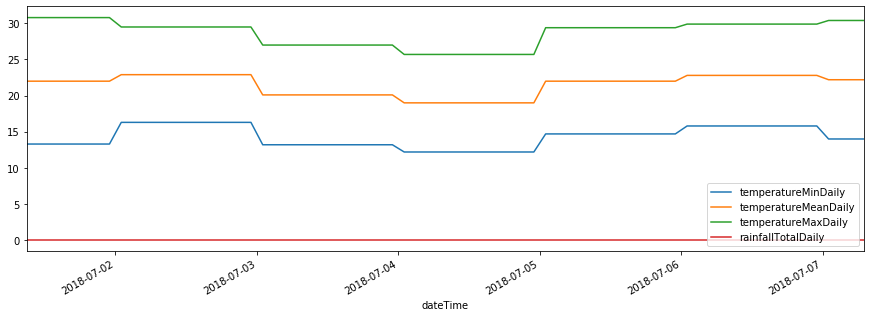

In [12]:
updated_details.plot(x='dateTime', y=['temperatureMinDaily', 'temperatureMeanDaily', 'temperatureMaxDaily', 'rainfallTotalDaily'], figsize=(15,5)).legend(loc='lower right');

Warm and dry! This is just a demonstration but you can see here that by obtaining both the cow's location and details of the environment it experienced we could start to look for new insights like the influence of temperature on behaviour or development.

We can also look at the location of the cow on a map. Below we use the google maps plugin and so to run the example you will need a google maps API key (see https://developers.google.com/maps/documentation/javascript/get-api-key). . Set the key below:

In [2]:
import os 

GMAPS_API_KEY = os.environ.get('GMAPS_API_KEY')
if GMAPS_API_KEY is None: 
    GMAPS_API_KEY = input("Please enter your Google maps API key:")

Please enter your Google maps API key:


Note if you are running the notebook locally, see also https://jupyter-gmaps.readthedocs.io/en/latest/install.html#installation to install the correct plugins to display the maps.

In [14]:
import gmaps
gmaps.configure(api_key=GMAPS_API_KEY)

# google maps api expects [lat, lon], not [lon, lat]
fixed_coordinates = [(lat, lon) for (lon, lat) in cow_location_details['point.coordinates']]

#Set up your map
fig = gmaps.figure(map_type='HYBRID')
fig.add_layer(gmaps.heatmap_layer(fixed_coordinates))
fig

Figure(layout=FigureLayout(height='420px'))